In [5]:
import matplotlib.pyplot as plt
import mplstereonet as stnt
import numpy as np
import pandas as pd
from pathlib import Path as pth
import sys

sys.path.append(str(pth.cwd().parents[0]))
from utils import *

In [2]:
# Auto KD Tree Facets
fct = pd.read_csv('../Files/Assgn_02/BD_auto_facets.csv', sep=';')
fct.columns = [name.lstrip().lower() for name in fct.columns] # Remove space from column names
fct['strike'] = dip_direction_to_strike(fct['dip dir.']) # Convert dip dir. to strike
fct = fct[fct.surface>0.3].reset_index(drop=True)           # Filter out surfaces < 0.1 m^2
fct.drop(columns='index', axis=1, inplace=True)
fct.to_csv('../Files/Assgn_03/BD_auto_facets_filtered_30cm.csv', index=False)

### Fracture Set 1 - Slope Stability Analysis
| Property | Angle(˚) |
| :------- | :------: |
| Dip Direction | 231 |
| Dip | 42.61 |
| Friction angle | 35 |

In [6]:
fs1 = pd.read_csv('../Files/Assgn_03/frac_set_1_subset.txt', sep='\t')
fs1.columns = [name.lstrip().lower() for name in fs1.columns]           # Remove space from column names
fs1['dip'] = 90 - fs1.plunge
fs1['strike'] = fs1['trend'] - 270 # Convert dip dir. to strike
sdl = pd.DataFrame({'strike': [211,251],'dip': [90,90]})           # Slope face direction limits
fap = pd.DataFrame({'trend':[0], 'plunge':[90], 'angle':[35]})     # Friction angle poles
sf1 = pd.DataFrame({'strike':[141], 'dip':[42.6]})                 # Slope face plane
pl_,td_,ag_ = calc_planar_daylight(sf1.strike, sf1.dip)
dp1 = pd.DataFrame({'trend':[td_], 'plunge':[pl_], 'angle':[ag_]}) # Calculate Daylight plane


# Fracture subset within daylight plane and lateral limits
fs1_sub = pd.read_csv('../Files/Assgn_03/frac_set_1_subset_within.txt', sep='\t')
fs1_sub.columns = [name.lstrip().lower() for name in fs1_sub.columns]
fs1_sub['strike'] = fs1_sub['trend'] - 270                            # Convert dip dir. to strike
fs1_sub['dip'] = 90 - fs1_sub.plunge
fs1_sub = fs1_sub[['trend','strike','plunge','dip']]

phi = 35     # Joint Friction angle (deg)
p = 0.05     # Water Pressure (MPa)
c0 = 0.03    # Joint Cohesion (MPa)
w = 25       # Block Weight (MN)
a = 100      # Joint surface area (m^2)
ah = 0.1     # Seismic Coefficient
bt = 4.5     # Total bolt force (MN)
w_a = w/a

def calc_factor_of_safety(c0,w,a,dip,phi, p, ah, bt, cal_type='dry'):
    # Dry Case
    if cal_type == 'dry':
        fs = c0 + ((w/a) * np.cos(np.radians(dip)) * 
                   np.tan(np.radians(phi))) / ((w/a) * np.sin(np.radians(dip)))
    if cal_type == 'saturated':
        num = (c0*a) + ((w * np.cos(np.radians(dip))) - 
                        (ah * w * np.sin(np.radians(dip))) - 
                        (bt * np.sin(np.radians(dip))) - 
                        (p * a)) * np.tan(np.radians(phi))
        den = ((w * np.sin(np.radians(dip))) - 
               (ah * w * np.cos(np.radians(dip))) - (
                   bt * np.cos(np.radians(dip))))
        fs = num/den
    return np.around(fs, 2)

fs_dry = calc_factor_of_safety(c0,w,a,fs1_sub.dip,phi,
                               p, ah, bt, cal_type='dry')
fs_sat = calc_factor_of_safety(c0,w,a,fs1_sub.dip,phi,
                               p, ah, bt, cal_type='saturated')


# Define the factor of safety for dry and saturated cases
fs1_sub['FS_dry'] = fs_dry
fs1_sub['FS_sat'] = fs_sat

fs1_sub['Failure_dry'] = np.where(fs_dry<1,0,1)
fs1_sub['Failure_sat'] = np.where(fs_sat<1,0,1)

# Calculate the probability of failure for each case
pof_dry = fs1_sub['Failure_dry'].sum() / len(fs1)
pof_sat = fs1_sub['Failure_sat'].sum() / len(fs1)


print(f"The probability of failure in the dry case is {pof_dry*100: .2f}%")
print(f"The probability of failure in the saturated case is {pof_sat*100: .2f}%")

The probability of failure in the dry case is  18.06%
The probability of failure in the saturated case is  22.92%


### Plot the stereonet

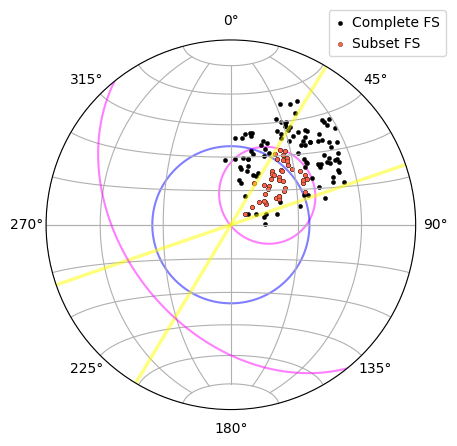

In [7]:
fig, ax = stnt.subplots()
ax.grid()

lw = 1.5

# Define line colors
sdl_col = 'yellow'
slf_col = 'magenta'
fap_col = 'b'

# alpha
aph = 0.5

ax.plane(sdl.strike, sdl.dip, color=sdl_col, lw=lw+1, alpha=aph)                     # Slope Direction limits
ax.plane(sf1.strike, sf1.dip, color=slf_col, lw=lw, alpha=aph)                       # Slope face and daylight plane
ax.cone(np.around(dp1.plunge[0]), dp1.trend, dp1.angle, lw=lw, color='None', ec=slf_col, alpha=aph)
ax.cone(fap.plunge, fap.trend, fap.angle, lw=lw, color='None', ec=fap_col, alpha=aph)# Friction angle poles
ax.pole(fs1.strike, fs1.dip, color='k', s=10, ec='k', marker='o', 
        ls='-',lw=0.2, label='Complete FS')                                          # Complete Fracture Set
ax.pole(fs1_sub.strike, fs1_sub.dip, color='tomato', s=10, ec='k', marker='o', 
        ls='-',lw=0.2, label='Subset FS')                                            # Subset Fracture Set
ax.legend(bbox_to_anchor=(1.1,1.1),handletextpad=0.5,handlelength=0.8,markerscale=1)
# plt.savefig('../Figures/Assgn_03_plane_failure_stereonet.png', dpi=200, facecolor='white', 
#             edgecolor='none', bbox_inches='tight')
plt.show()